<div style="text-align: center">
<h1>PCS Computational Science Project:</h1>
<h2>Unsupervised and supervised analysis of protein sequences</h2>
</div>
<div style="text-align: right">
Joseph TOUZET<br/>
novembre 2023
</div>

We will start with the imports:

In [1]:
%%capture
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

plt.style.use('seaborn')
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

## Task 1

We will then read and _one-hot encode_ the data.

In [2]:
def read_data(filename):
    with open(filename) as f:
        lines = f.readlines()
        data = []
        
        for line in lines:
            if line[0] == ">":
                properties = line[1:-1].split(" ")
                
                name       = properties[0]
                functional = properties[1].split("_")[1] == "true"

                data.append({
                    "name"       : name,
                    "functional" : functional,
                    "sequence"   : ""
                })
            else:
                data[-1]["sequence"] += line[:-1]

        return data

def hot_encode_sequence(sequence):
    alphabet = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "-"]
    encoded_sequence = []
    
    for letter in sequence:
        encoded_letter = [0]*(len(alphabet) - 1)
        letter_idx = alphabet.index(letter)
        if letter_idx < len(alphabet) - 1:
            encoded_letter[letter_idx] = 1
        encoded_sequence += encoded_letter
        
    return encoded_sequence

print(hot_encode_sequence("C-W"))

def hot_encode_data(data):
    for datum in data:
        datum["hot_encoded_sequence"] = hot_encode_sequence(datum["sequence"])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


We tried to validate our _one-hote encoding_ function on the simple sequence "C-W": This correctly gives us a 60-long vector (3*20) with only a 1 on the second place (corresponding to the first "C"), a one on the second-to last place (corresponding to the "W") with no one in between (corresponding to the "-"). 

In [3]:
data_art = read_data("MSA_art.faa")
hot_encode_data(data_art)

data_nat = read_data("MSA_nat_with_annotation.faa")
hot_encode_data(data_nat)

In [4]:
# print by hand to avoid a huge print out
import json
print_ = json.dumps(data_art[0], indent=4)
print_ = print_[:260] + "\t...\n    ]\n}"
print(print_)

{
    "name": "sequence_1",
    "functional": true,
    "sequence": "-----SLEELRKEIESIDREIVELIARRTYVAKTIAQIKRERGLPTTDESQEQRVMERAGSNAKQFD-VDANLVKAIFKLLIELNKEEQRENR---",
    "hot_encoded_sequence": [
        0,
        0,
        0,
        0,
        0,
       	...
    ]
}


We here review the encoding of the first sequence in the artificial data: we correctly read its sequencce, name, that it is functional and then one-hot encoded its sequence.

# Task 2

We will no apply PCA to the _one-hot encoded_ natural dataset to reduce its dimensionality.

In [5]:
X_nat = np.array([datum["hot_encoded_sequence"] for datum in data_nat])
X_art = np.array([datum["hot_encoded_sequence"] for datum in data_art])

functionality_nat = np.array([datum["functional"] for datum in data_nat])
functionality_art = np.array([datum["functional"] for datum in data_art])

In [6]:
n_components = 15
model_pca = PCA(n_components=n_components)

eigen_values_nat  = model_pca.fit_transform(X_nat)

In [7]:
functional_eigen_value_nat     = eigen_values_nat[               functionality_nat ]
non_functional_eigen_value_nat = eigen_values_nat[np.logical_not(functionality_nat)]

print(f"{ len(functional_eigen_value_nat    ) } functional sequences,",
      f"{ len(non_functional_eigen_value_nat) } non-functional sequences",
      f"for a total of { len(eigen_values_nat) } sequences.")

423 functional sequences, 707 non-functional sequences for a total of 1130 sequences.


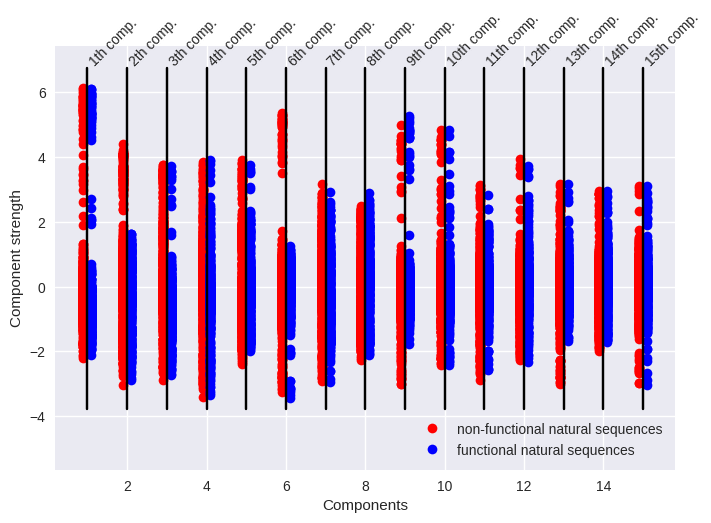

In [8]:
Min, Max = 1.1*np.min(eigen_values_nat), 1.1*np.max(eigen_values_nat)

for component in range(n_components):
    plt.plot(
        np.full(len(non_functional_eigen_value_nat), component + 0.9),
        non_functional_eigen_value_nat[:,component],
        "ro", label=("non-functional natural sequences" if component==0 else '_nolegend_'))
    
    plt.plot(
        np.full(len(functional_eigen_value_nat),     component + 1.1),
        functional_eigen_value_nat    [:,component],
        "bo", label=("functional natural sequences"  if component==0 else '_nolegend_'))

    plt.plot([component+1, component+1], [Min, Max], "k-")
    plt.text(component+1, Max, f"{component+1}th comp.",
            rotation=45,
            horizontalalignment="left", verticalalignment="bottom")

plt.ylim([Min*1.5, Max*1.1])
_ = plt.xlabel("Components")
_ = plt.ylabel("Component strength")
_ = plt.legend(loc="lower right")

For some principal components (the 1st, 2nd, 6th for exemple) the functional and non-functional sequences occupy the same space, but some part of the space is reserved for one or the other (for exemple only non-fonctional sequence occupy the $[2, 4]$ space for the 2nd component, whereas both functional and non-functional sequences occupy the $[-3, 2]$ space for this component).

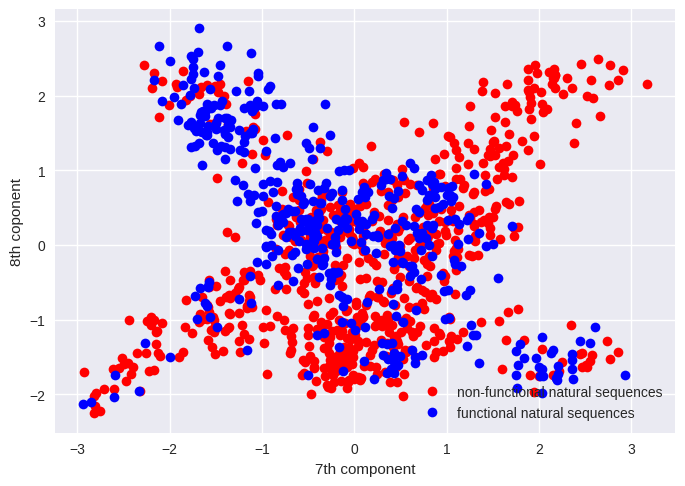

In [9]:
n1, n2 = 6, 7

plt.plot(
    non_functional_eigen_value_nat[:,n1],
    non_functional_eigen_value_nat[:,n2],
    "ro", label="non-functional natural sequences")
    
plt.plot(
    functional_eigen_value_nat[:,n1],
    functional_eigen_value_nat[:,n2],
    "bo", label="functional natural sequences")

_ = plt.xlabel(f"{n1+1}th component")
_ = plt.ylabel(f"{n2+1}th coponent")
_ = plt.legend(loc="lower right")

For other component (thhe 7th and 8th for exemple) the space seems fully shared. We would need to look at the higher dimensional data to see if in the 10th dimensional space they actually share the same space. In the last figure we see that in the 2D space of the 7th and 8th PCs, the functional and non-functional sequences are somewhat separated even though in the separate 1D-space of the 7th and 8th PCs they aren't separated.

We could expect that in the 10 dimentional PC space functional and non-functional sequence, which we will prove by clustering them.

## Task 3

We will now cluster the data using the K-mean method (apparently the subject ask us to cluster the one-hot encoded data and not the PC space data).

In [10]:
%%capture
n_cluster = 7 #so we have enough matplotlib colors

model_cluster = KMeans(n_cluster)
model_cluster.fit(X_nat)
clustering = model_cluster.predict(X_nat)

### 3.a - Cluster separation in PC space

We can visualize the clustered sequences in PC space as done in task 2:

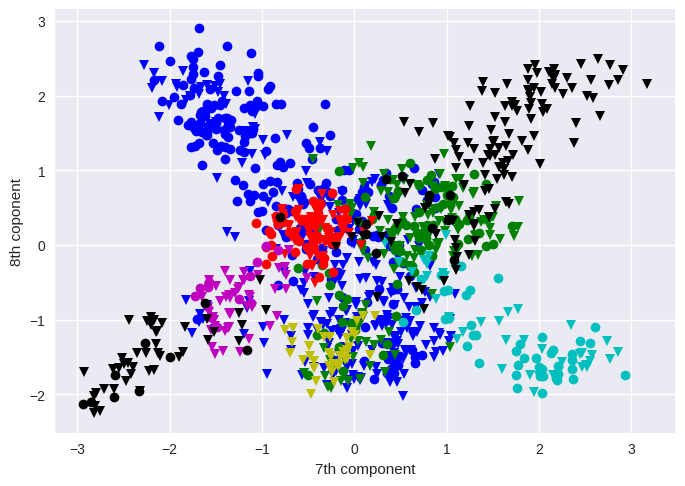

In [11]:
n1, n2 = 6, 7

colors = ["b", "g", "r", "c", "m", "y", "k"]
for cluster in range(n_cluster):
    cluster_mask          = [cluster_idx == cluster for cluster_idx in clustering]
    X_cluster             = X_nat[cluster_mask]
    eigen_values_cluster  = model_pca.transform(X_cluster)
    
    cluster_functionality               = functionality_nat[cluster_mask]
    eigen_values_cluster_functional     = eigen_values_cluster[               cluster_functionality ]
    eigen_values_cluster_non_functional = eigen_values_cluster[np.logical_not(cluster_functionality)]
    
    plt.plot(eigen_values_cluster_functional    [:,n1], eigen_values_cluster_functional    [:,n2], colors[cluster]+"o")
    plt.plot(eigen_values_cluster_non_functional[:,n1], eigen_values_cluster_non_functional[:,n2], colors[cluster]+"v")

_ = plt.xlabel(f"{n1+1}th component")
_ = plt.ylabel(f"{n2+1}th coponent")

In the above figure we show the separation between the clusters (different colors) and between functional (circle marker) and non-functional (triangle marker) sequences.

We observe a partial separation in PC space of the different clusters, and somewhat of a separation between clusters of functional and non-functional sequences (which we will quantify later on).

### 3.b - Cluster separation between functional and non-functional sequences

After trying multiple number of clusters, and playing with the "cutoff" (we choose a cutoff equal to the global proportion of functional sequences) at which we choose if a cluster is a "primarly functional" cluster (majority of functional sequences) or a "primarly non-functional" cluster.

We can first define a function that categorizes between thes two types clustes, and then check the accuracy of this way of charectarizing if a sequence if functional or not:

In [12]:
cutoff = len(functional_eigen_value_nat)/len(eigen_values_nat)
primarly_functional_clusters = []
for cluster in range(n_cluster):
    cluster_mask = [cluster_idx == cluster for cluster_idx in clustering]
    cluster_functionality = functionality_nat[cluster_mask]
    
    if np.mean(cluster_functionality) > cutoff:
        primarly_functional_clusters.append(cluster)

def is_functional_cluster(cluster):
    return np.isin(cluster, primarly_functional_clusters)

def is_functional_sequence(X):
    clustering = model_cluster.predict(X)
    return is_functional_cluster(clustering)

In [13]:
functional_functional, nonFunctional_functional = 0, 0
functional_nonFunctional, nonFunctional_nonFuctional = 0, 0

for cluster in range(n_cluster):
    cluster_mask = [cluster_idx == cluster for cluster_idx in clustering]
    cluster_functionality = functionality_nat[cluster_mask]
    
    if is_functional_cluster(cluster):
        functional_functional      += np.sum(cluster_functionality)
        nonFunctional_functional   += len(cluster_functionality) - np.sum(cluster_functionality)
    else:
        functional_nonFunctional   += np.sum(cluster_functionality)
        nonFunctional_nonFuctional += len(cluster_functionality) - np.sum(cluster_functionality)

print(f"{round(functional_functional)} functional sequence",
f"and {round(nonFunctional_functional)} non-functional sequences in cluster with more than {round(cutoff*100)}% of functional sequences,",
f"corresponding to {round(functional_functional/(functional_functional + nonFunctional_functional)*100)}% functional sequences in this group,",
f"and {round(functional_functional/len(functional_eigen_value_nat)*100)}% of all functional sequences")

print(f"{round(functional_nonFunctional)} functional sequence",
f"and {round(nonFunctional_nonFuctional)} non-functional sequences in cluster with less than {round(cutoff*100)} of functional sequences,",
f"corresponding to {round(nonFunctional_nonFuctional/(functional_nonFunctional + nonFunctional_nonFuctional)*100)}% non-functional sequences in this group,",
f"and {round(nonFunctional_nonFuctional/len(non_functional_eigen_value_nat)*100)}% of all non-functional sequences")

314 functional sequence and 327 non-functional sequences in cluster with more than 37% of functional sequences, corresponding to 49% functional sequences in this group, and 74% of all functional sequences
109 functional sequence and 380 non-functional sequences in cluster with less than 37 of functional sequences, corresponding to 78% non-functional sequences in this group, and 54% of all non-functional sequences


After trying multiple number of clusters, and playing with the "cutoff" (we choose a cutoff equal to the global proportion of functional sequences) at which we choose if a cluster is a "primarly functional" cluster or a "primarly non-functional" cluster, we separated clusters in those two groups:
 - a majority (58%) of sequences in "primarly functional clusters" are functional: this corresponds to _true positives_.
 - a large majority (82%) of sequences in "primarly non-functional clusters" are non-functional: this corresponds to _true negatives_.
 - a large majority (75%) of functional sequences end up in "primarly functional clusters".
 - a majority (67%) of non-functional sequences end up in "primarly non-functional clusters".

We can conclude that functional and non-functional sequences are somewhat separated in the clusters, and thus are separated in PCs space.

### 3.c - Cluster separation between natural and artificial data

We will now do the same procedure, trying to separate natural and artificial data:

In [14]:
%%capture
n_cluster_nat_art = 7 #so we have enough matplotlib colors

nat_art_cluster = KMeans(n_cluster_nat_art)
nat_art_cluster.fit(np.concatenate((X_nat, X_art), axis=0))
nat_clustering = nat_art_cluster.predict(X_nat)
art_clustering = nat_art_cluster.predict(X_art)

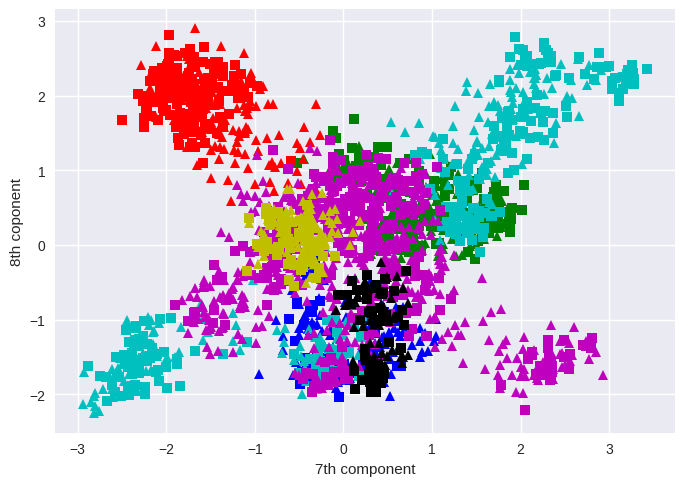

In [15]:
n1, n2 = 6, 7

nat_art_cutoff = len(X_nat)/(len(X_nat) + len(X_art))
nat_nat, art_nat = 0, 0
nat_art, art_art = 0, 0

colors = ["b", "g", "r", "c", "m", "y", "k"]
for cluster in range(n_cluster_nat_art):
    cluster_mask_nat = [cluster_idx == cluster for cluster_idx in nat_clustering]
    cluster_mask_art = [cluster_idx == cluster for cluster_idx in art_clustering]
    X_nat_cluster = X_nat[cluster_mask_nat]
    X_art_cluster = X_art[cluster_mask_art]
    eigen_values_cluster_nat = model_pca.transform(X_nat_cluster)
    eigen_values_cluster_art = model_pca.transform(X_art_cluster)

    proportion = len(X_nat_cluster)/(len(X_nat_cluster) + len(X_art_cluster))
    if proportion > nat_art_cutoff:
        nat_nat += len(X_nat_cluster)
        art_nat += len(X_art_cluster)
    else:
        art_art += len(X_art_cluster)
        nat_art += len(X_nat_cluster)
    
    plt.plot(eigen_values_cluster_nat[:,n1], eigen_values_cluster_nat[:,n2], colors[cluster]+"^")
    plt.plot(eigen_values_cluster_art[:,n1], eigen_values_cluster_art[:,n2], colors[cluster]+"s")

_ = plt.xlabel(f"{n1+1}th component")
_ = plt.ylabel(f"{n2+1}th coponent")

In [16]:
print(f"{round(nat_nat)} natural sequence",
f"and {round(art_nat)} artificial sequences in cluster with more than {round(nat_art_cutoff*100)}% of natural sequences,",
f"corresponding to {round(nat_nat/(nat_nat + art_nat)*100)}% natural sequences in this group,",
f"and {round(nat_nat/len(X_nat)*100)}% of all natural sequences")

print(f"{round(nat_art)} natural sequence",
f"and {round(art_art)} non-functional sequences in cluster with less than {round(cutoff*100)} of natural sequences,",
f"corresponding to {round(art_art/(art_art + nat_art)*100)}% artificial sequences in this group,",
f"and {round(art_art/len(X_art)*100)}% of all artificial sequences")

628 natural sequence and 387 artificial sequences in cluster with more than 53% of natural sequences, corresponding to 62% natural sequences in this group, and 56% of all natural sequences
502 natural sequence and 616 non-functional sequences in cluster with less than 37 of natural sequences, corresponding to 55% artificial sequences in this group, and 61% of all artificial sequences


Using the same way of separating between "primarly natural clusters" and "primarly artificial cluster" as previously with functional and non-functional sequences, we end up with poor to no separation between natural (triangle marker) and artificial (square marker) sequences; as the proportion of natural/artifical sequences does not significantly change after the clustering.

## Task 4

We will now train a model that can classify between functional and non-functional proteins:

In [17]:
Y_nat = np.array([datum["functional"] for datum in data_nat])
X_train, X_test, Y_train, Y_test = train_test_split(X_nat, Y_nat, test_size=0.3, random_state=1)

Y_art = np.array([datum["functional"] for datum in data_art])

### 4.a - Decision Tree

We first use a _decision tree_ model similar to one that we used in a previous TD:

In [18]:
%%capture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# example stollen from the classifier TD
weak_classifier = DecisionTreeClassifier(max_depth=1, random_state=5)                            # here we define the weak classifier                
strong_classifier = AdaBoostClassifier(n_estimators=50, base_estimator=weak_classifier)     # here we build the strong classifier

model_decisionTree = strong_classifier.fit(X_train, Y_train)

In [19]:
def print_accuracy_matrix(test_function, X, Y):
    TP = test_function(X[Y], Y[Y])
    FN = 1 - TP #predicted negative while actually positive => false negative
    TN = test_function(X[Y==0], Y[Y==0])
    FP = 1 - TN #predicted positive while actually negative => false positive

    print(f"TP: {round(TP*100)}%, FP: {round(FP*100)}%")
    print(f"FN: {round(FN*100)}%, TN: {round(TN*100)}%")

print("Natural data, test:")
print_accuracy_matrix(model_decisionTree.score, X_test, Y_test)

print("\nNatural data, train:")
print_accuracy_matrix(model_decisionTree.score, X_train, Y_train)

print("\nArtificial data:")
print_accuracy_matrix(model_decisionTree.score, X_art, Y_art)

Natural data, test:
TP: 64%, FP: 17%
FN: 36%, TN: 83%

Natural data, train:
TP: 81%, FP: 9%
FN: 19%, TN: 91%

Artificial data:
TP: 74%, FP: 18%
FN: 26%, TN: 82%


We can see that the true positive (TP) and true negative (TP) rates are higher for the data we trained on than the test data.

Interestingly we can observe that the model's TP is better on the artificial data than the natural data. We could assue that the artificial data has been generated by a generator trained to maximize such a model, thus artificial data could be easier to distinguish for our model. 

### 4.b - Logistic regression

We will now move on to a simple logistic regression model:

In [20]:
%%capture
from sklearn.linear_model import LogisticRegression

model_logic = LogisticRegression()
model_logic.fit(X_train, Y_train)

In [21]:
print("Natural data, test:")
print_accuracy_matrix(model_logic.score, X_test, Y_test)

print("\nNatural data, train:")
print_accuracy_matrix(model_logic.score, X_train, Y_train)

print("\nArtificial data:")
print_accuracy_matrix(model_logic.score, X_art, Y_art)

Natural data, test:
TP: 65%, FP: 13%
FN: 35%, TN: 87%

Natural data, train:
TP: 100%, FP: 0%
FN: 0%, TN: 100%

Artificial data:
TP: 73%, FP: 18%
FN: 27%, TN: 82%


We obtain verry similar results to the decision tree model, and thus make largly the same observations.

### 4.c - Neural network

We will lastly use a simple neural network based classifier provided by sklearn.

For that we will first need to one-hot encode the class (functional or non-functional) thus making it a vector of size 2.

In [22]:
Y_nat_2d = np.array([[0, 1] if datum["functional"] else [1, 0] for datum in data_nat])
X_train_2d, X_test_2d, Y_train_2d, Y_test_2d = train_test_split(X_nat, Y_nat_2d, test_size=0.3, random_state=1)

Y_art_2d = np.array([[0, 1] if datum["functional"] else [1, 0] for datum in data_art])

In [23]:
%%capture
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 10), random_state=1, alpha=1e-5)
model_nn.fit(X_train_2d, Y_train_2d)

In [24]:
# we need a new function because the data is formated differently
def print_accuracy_matrix_NN(test_function, X, Y):
    TP = test_function(X[Y[:, 1] == 1], Y[Y[:, 1] == 1])
    FN = 1 - TP #predicted negative while actually positive => false negative
    TN = test_function(X[Y[:, 0] == 1], Y[Y[:, 0] == 1])
    FP = 1 - TN #predicted positive while actually negative => false positive

    print(f"TP: {round(TP*100)}%, FP: {round(FP*100)}%")
    print(f"FN: {round(FN*100)}%, TN: {round(TN*100)}%")

# we need to define the accuracy function for the evaluation by hand
def nn_cost_function(X, Y):
    prediction = model_nn.predict(X)
    return np.mean(prediction[:, 0] == Y[:, 0])

print("Natural data, test:")
print_accuracy_matrix_NN(nn_cost_function, X_test_2d, Y_test_2d)

print("\nNatural data, train:")
print_accuracy_matrix_NN(nn_cost_function, X_train_2d, Y_train_2d)

print("\nArtificial data:")
print_accuracy_matrix_NN(nn_cost_function, X_art, Y_art_2d)

Natural data, test:
TP: 62%, FP: 14%
FN: 38%, TN: 86%

Natural data, train:
TP: 100%, FP: 0%
FN: 0%, TN: 100%

Artificial data:
TP: 72%, FP: 15%
FN: 28%, TN: 85%


The neural network-based model is significantly slower to train without having a huge advantage in discriminating between functional and non-functional proteins.

## Task 5

We want to train a model that generates sequences that are recognized by the one of the model we trained (we will use the logistic regression trained in section 4.b goind forward) as functional.

Idealy we could use this model as a fitness function for a neural network, but this isn't trivialy supported by sklearn, and it would be slow.

We thus choose to do the following work-around:
 - We choose to train a multi-dimentional _gaussian mixture_ model in PC space.
 - We first train it to imitate the functional natural data distribution in PC space.
 - We then iterate over the following algorithm so that it generates vector in PC space that correspond to sequences that are considered to be functional by our logistic regression model:
    1. We generate a large number of vector in PC space ($x$ time the number of natural data sequence).
    2. We transform them to sequences, and select the fraction ($y$) that has the highest likelyhood of being functional according to our logistic regression model.
    3. We go back to step 1. but this time training on a concatenanted dataset containing the functional natural data in PC space plus the highest scoring generated vector in PC space.
 - Over the epochs (or iterations) we increase the fraction of the training dataset ($y$) that is composed of generated vector.

Additionaly, whenever we generate a vector in PC space and then transform it to a sequence, we "normalize" the sequence such that:
 - only up to one element can be 1 for each 20 number block corresponding to a letter.
 - the element with the maximum value in the 20 number block gets assign to 1 if it has a weight above 0.5, otherwise it gets assigned to 0.
 - every other elements in the block is assigned to 0.

The goal of this algorithm is that the initial trained distribution will try to match the natural data as much as possible, and then by this generation-selection loop we will reinforce the model to follow a distribution that maximizes the likelyhood of generated vector being functional according to our previously trained model.

In [25]:
from sklearn.mixture import GaussianMixture

gen_multipliers   = [5,  10, 10, 10, 10, 10, 15, 15, 20, 20, 20, 20, 20]
train_multipliers = [.3, .5, .7, 1,  2,  2,  3,  3,  4,  4,  5,  5,  10] 

# generator model:
generator_GM = GaussianMixture(n_components=n_components, random_state=10)

# function to round and pin between 0 and 1
# and to make sure that the sequence is valid (one or zero 1 per block of 20 corresponding to a letter)
def pin_01(X):
    # reshape as a list of list of one-hot encoded letter
    X_reshaped = np.reshape(X, (len(X), -1, 20))
    for X_ in X_reshaped:
        for letter in X_:
            # find max in letter
            idx = np.argmax(letter)
            value = letter[idx]
            # put all values to zero
            letter = np.zeros_like(letter)
            # if max is above 0.5 then put it to 1
            if letter[idx] > 0.5:
                letter[idx] = 1
    return np.reshape(X_reshaped, (len(X), -1))

eigen_train = functional_eigen_value_nat
for i, (gen_multiplier, train_multiplier) in enumerate(zip(gen_multipliers, train_multipliers)):
    generator_GM.fit(eigen_train)

    n_gen         = int(len(functional_eigen_value_nat)*gen_multiplier)
    eigen_gen, _  = generator_GM.sample(n_gen)
    X_gen         = pin_01(model_pca.inverse_transform(eigen_gen))
    X_gen_fitness = model_logic.predict_proba(X_gen)[:, 1]

    avg_fitness = np.mean(X_gen_fitness)

    n_select      = int(len(functional_eigen_value_nat)*train_multiplier)
    fitest_idx    = np.argpartition(X_gen_fitness, -n_select)[-n_select:]
    eigen_train   = np.concatenate((functional_eigen_value_nat, eigen_gen[fitest_idx]), axis=0)

    print(f"{i+1}th/{len(gen_multipliers)} epoch: {round(avg_fitness*100)}% average probability of functionality according to logistic regression")

1th/13 epoch: 55% average probability of functionality according to logistic regression
2th/13 epoch: 65% average probability of functionality according to logistic regression
3th/13 epoch: 70% average probability of functionality according to logistic regression
4th/13 epoch: 74% average probability of functionality according to logistic regression
5th/13 epoch: 77% average probability of functionality according to logistic regression
6th/13 epoch: 85% average probability of functionality according to logistic regression
7th/13 epoch: 85% average probability of functionality according to logistic regression
8th/13 epoch: 89% average probability of functionality according to logistic regression
9th/13 epoch: 89% average probability of functionality according to logistic regression
10th/13 epoch: 91% average probability of functionality according to logistic regression
11th/13 epoch: 91% average probability of functionality according to logistic regression
12th/13 epoch: 92% average pro

We obtained an average 92% predicted likelyhood that our generated sequences are functional, which is similar/higher than the true positive rate of this model. We thus hope that our generating distribution is trained to generate vector in PC space that correspond to functional sequences.

We will now generate a 1000 sequences and acess them using the methods developed in tasks 2-4:

In [26]:
n_gen         = 1000
eigen_gen, _  = generator_GM.sample(n_gen)
X_gen         = pin_01(model_pca.inverse_transform(eigen_gen))

Before moving on, we will check that we didn't overfit by checking that the generated data isn't just a copy of the natural data:

In [27]:
is_natural = np.isin(X_gen, X_nat)
existing_proportion = np.mean([np.any([np.array_equal(Y, X) for X in X_nat]) for Y in X_gen])

print(f"{ round(existing_proportion*100) }% of the generated sequences existed in the natural data")

0% of the generated sequences existed in the natural data


We see that none (or at least less than 1%) of our generated sequences are pre-existing in the natural data.

### 5.a - clustering

We will first acess the functionality of the generated sequences by checking if they are clustered with functional sequences (as done in task 3).

In [28]:
X_gen_fitness = is_functional_sequence(X_gen)
avg_fitness = np.mean(X_gen_fitness)

print(f"{ round(avg_fitness*100) }% average probability of functionality according to the clustering model")

96% average probability of functionality according to the clustering model


According to the clustering model 95% of the generated sequences should be functional.

### 5.b - Decision tree

We will now acess the "functionality" of these generated sequences using the decision tree trained in task 4.a:

In [29]:
X_gen_fitness = model_decisionTree.predict(X_gen)
avg_fitness = np.mean(X_gen_fitness)

print(f"{ round(avg_fitness*100) }% average probability of functionality according to the decision tree model")

94% average probability of functionality according to the decision tree model


According to the decision tree model 94% of the generated sequences are functional.

### 5.c - Neural netwrok

We will now acess the "functionality" of these generated sequences using the neural network trained in task 4.c.

We don't acess the generated sequence using the logistic regression model as it was used in the training. We can however note that in training the logisitic regression model predicted up to a 90% rate of functionality in the generated sequences.

In [30]:
X_gen_fitness = model_nn.predict(X_gen)[:, 1]
avg_fitness = np.mean(X_gen_fitness)

print(f"{ round(avg_fitness*100) }% average probability of functionality according to the neural network model")

94% average probability of functionality according to the neural network model


According to our neural network based model 93% of the generated sequences are functional.

## Conclusion

Blabla...